# 1. Phylogenetic reconstruction of an 18S tree for species with genomes
**Objective**: Make a tree from 18S rRNA sequences representing the Nematoda species with genomes. It will serve for phylogenetically controlled trait evolution analysis, the traits being TE loads.  
**Strategy**:  

1. Build a large ML tree with all the Silva Nematoda species, the genome species and outgroup species.  
    a. Use a SINA alignment (done online) accounting for secondary structure  
    b. Trim with TrimAl gappyout  
    c. Reconstruct with RAxML using 50 starting trees and turough bootstrap analysis.
2. Extract a tree with only the genome species out of the large tree and outgroup species. This will reduce species representation artifacts compared to a tree reconstruction, which includes only the genome species from the start.
    a. Use ReproPhylo to add a qualifier with a species name code in records I want to keep in the trimmed tree. This qualifier is called "keep".
    b. Use ete to trim the tree.
    c. Use Biopython to make a trimmed alignment containing only the species that are in the trimmed tree.
3. Build a bayesian tree with Phylobayes, using the trimmed ML tree as a starting tree and the reduced alignment as character matrix. This has two puposes: take advantage of the GTR-CAT model and generate a posterior distribution of trees to account for phylogenetic uncertainty in the BayesTraits computations of tree transformation and the alpha prameter.
  
**Additional analyses in this notebook:**  

1. Calculate the genome GC content and N50 length for each of the species and add these as feature qualifiers to the ReproPhylo Project.  
2. Confirm no correlation between N50, GC content, genome length (from database) and assembly length (calculated). 

## 1.1 Phylogenetic 18S rRNA Data

In [40]:
from Bio import SeqIO

# Nematoda 18S rRNA sequences from SILVA
records = list(SeqIO.parse('18S_tree/data/arb-silva.de_2014-03-27_id165489.fasta','fasta'))

# 18S rRNA sequences from genome assemblies
hits = list(SeqIO.parse('18S_tree/data/18S_from_genomes.fas','fasta'))
for hit in hits:
    hit.seq = hit.seq.transcribe()
    records.append(hit)
    
# A fasta file with both    
SeqIO.write(records, '18S_tree/data/nematoda_18S_020314.fasta','fasta')

187

## 1.2 [SINA](http://www.arb-silva.de/aligner/) Sequence alignment
Online sequence alignment:  

+ **input**:`nematoda_18S_020314.fasta`  
+ **output**: `nematoda_18S_020314.sina.fasta`   
+ **Settings**:  
    + "bases ramining unaligned at the end of sequences"  
    + "reject seqeunces below 70% identity"

## 1.3 Feed the SINA alignment to a new ReproPhylo Project

In [180]:
from reprophylo import *
# Start a Project with a bin for 18S rRNA sequences
pj = Project([Locus('dna','rRNA','18S',['18S'])])

# Read the alignment
pj.read_alignment('18S_tree/data/nematoda_18S_020314.sina.fasta',
                  'dna','rRNA', '18S', aln_method_name='SINA')

## 1.4 Add organism qualifier to all the records in the Project
Bclades are [Blaxter et al 1998](http://www.nature.com/nature/journal/v392/n6671/full/392071a0.html) clades taken from [here](http://www.nematodes.org/nematodegenomes/index.php/Systematic_Tree_of_Nematoda)  
###Input 1: Silva species names

In [4]:
!head 18S_tree/data/silva_species_names_by_accession.txt

AJ920342.1.1737	Cylicocyclus insigne
AJ966502.1.1749	Radopholus similis
CACX01001817.29572.31281	Strongyloides ratti
AB205054.1.1740	Strongyloides procyonis
AY508018.1.1708	Bursaphelenchus hofmanni
AY508014.1.1706	Bursaphelenchus fraudulentus
JX154585.1.1711	Bursaphelenchus sp. JW-2012
FJ501985.1.1706	Bursaphelenchus doui
AF202165.1.1741	Turbatrix aceti
AF036599.1.1759	Panagrellus redivivus


###Input 2: Genome assemblies taxonomy

In [5]:
!head 18S_tree/data/species_names.csv

Rcul	Romanomermis culicivorax	Mermithida	I
Tspi	Trichinella spiralis	Trichinellida	I
Tmur	Trichuris muris	Trichinellida	I
Sbat	Soboliphyme baturini		I
Ttri	Trichuris trichiura	Trichinellida	I
Ebre	Enoplus brevis	Enoplida	II
Smur	Syphacia muris		III
Asuu	Ascaris suum	Ascaridomorpha	III
Wban	Wuchereria bancrofti	Spiruromorpha	III
Avit	Acanthocheilonema viteae	Spiruromorpha	III


In [181]:
## Inputs ##
# tab delimited lines: <silva accession><tab><species binomial>
lines = open('18S_tree/data/silva_species_names_by_accession.txt','r').readlines()
# tab delimited lines: <genome species codes><tab><species binomial><tab><order><tab><Bclade>
lines += open('18S_tree/data/species_names.csv','r').readlines() 

species_by_seqid = {}
clade_by_seqid = {}

# Parse taxonomy
for line in lines:
    try:
        if not line.split('\t')[0] in species_by_seqid.keys():
            species_by_seqid[line.split('\t')[0]] = line.split('\t')[1].rstrip()
            # For SILVA species, binomial will also be used as clades, but the silva
            # species will not make it into the trimmed tree anyway.
            clade_by_seqid[line.split('\t')[0]] = line.split('\t')[-1].rstrip()
    except:
        print line
        
# Add the species and clade as source feature qualifiers in each of the records
for record in pj.records:
    source = [f for f in record.features if f.type == 'source'][0]
    source.qualifiers['organism'] = [species_by_seqid[source.qualifiers['original_id'][0]]]
    source.qualifiers['clade'] = [clade_by_seqid[source.qualifiers['original_id'][0]]]

## 1.5 Mark leaves to keep (representatives of the genome species)
Add a qualifier that would indicate which records will make it into the trimmed tree. For some species, the SILVA sequence will be prefered over the sequence obtained from the genome because it is identical but longer. 

In [182]:
ids_to_keep = [i.split()[0] for i in open('Genomes/genome_assembly_files_v3.csv','r').readlines() if '+' in i]
print ids_to_keep

['Acan', 'Asim', 'Bpah', 'Btim', 'Eela', 'Ever', 'Hbak', 'Ooch', 'Ovol', 'Ptri', 'Sbat', 'Spap', 'Srat', 'Sven', 'Smur', 'Tcan', 'Ttri', 'Wban', 'Mflo', 'Dviv', 'Ebre', 'Rcul', 'Avit', 'Asuu', 'Bxyl', 'Hbac', 'Haor', 'Hcon', 'briC', 'Cele', 'Cjap', 'Bmal', 'Cbre', 'Crem', 'Gpal', 'Lsig', 'Ppac', 'Lloa', 'Mhap', 'Minc', 'C5sp', 'Dimm', 'Otip', 'Pred', 'C11sp', 'Cang', 'Tmur', 'Tspi', 'Acas', 'Agam', 'Acal', 'Dpul', 'Dsim', 'Lgi', 'Nvi', 'Nve', 'Ath', 'Vcar', 'Alyr', 'Hduj', 'Gros', 'Mchi', 'Rsim', 'Pcof', 'Mjav']


### Pick a SILVA sequence substitue for some of the genome assembly species

In [183]:
silvaid_to_genomecode = {'U88336.1.1797': 'Ebre',
                         'AF036593.1.1718': 'Hbac',
                         'JN636061.214.1967': 'briC',
                         'AF227233.1.1676': 'Lsig',
                         'AF036638.1.1732': 'Dimm',
                         'AF036599.1.1759': 'Pred',
                         'AF083006.1.1701': 'Cang', 
                         'EU130798.1.855': 'Pcof',
                         'AF036591.1.1679': 'Otip',
                         'AY942621.1.1655': 'Mflo',
                         'AY593888.1.1695': 'Mchi',
                         'AY268121.1.1756': 'Mjav',
                         'U13931.1.1685': 'Crem',
                         'JN636063.1.1724': 'C11sp',
                         'AY295804.1.1691': 'Acan',
                         'U94366.1.1754': 'Alum',
                         'JF934731.1.1825': 'Ever',
                         'AB495389.1.1782': 'Gpul',
                         'L04154.3.1750': 'Hpla',
                         'AJ920356.1.1737': 'Nbra',
                         'DQ094174.1.1774': 'Ofle',
                         'U94378.1.1754': 'Pequ',
                         'AJ417024.1.1153': 'Ptri',
                         'AY277895.1.1743': 'Sbat',
                         'AB453323.1.1250': 'Spap',
                         'M84229.1.1766': 'Sste',
                         'AB453330.1.1247': 'Sven',
                         'EF464553.1.1262': 'Smur',
                         'DQ118536.1.1867': 'Ttri',
                         'AF519224.1.1727': 'Haor',
                         }

# Cgol not in silva, blast gives only fungi sequences. excluded from analysis
# Eela, Haor not in silva and not found in assembly. Excluded
# Ooch not in silva and cannot be found in assembly. Excluded
# 10/4/15 Ooch and Haor now in silva. 

pj.add_qualifier_from_source('original_id') # Move the value from source feature to sequence feature

for i in ids_to_keep: # 18S sequences from genomes
    pj.if_this_then_that(i, 'original_id', i, 'keep')

# 18S sequences from Slilva that will represent genomes for which 18S was not retrieved
# or is not long enough
for i in silvaid_to_genomecode: 
    if silvaid_to_genomecode[i] in ids_to_keep:
        pj.if_this_then_that(i, 'original_id', silvaid_to_genomecode[i], 'keep')

## 1.6 Check which genome assemblies are not represented in the trimmed tree

In [185]:
import TE
from itertools import chain

# Get all the genome codes
codes = TE.genome_codes_list('Genomes/', mode='++',
                             code_file='genome_assembly_files_v3.csv')

# Get all the trimmed tree genome codes
edges_im_tree = [f.qualifiers['keep'][0] for f 
                 in chain(*[r.features for r in pj.records]) 
                 if 'keep' in f.qualifiers.keys()]

# Analyzed genomes that are not represented in the tree:
print [code for code in codes if not code in edges_im_tree]
# Eela is not in Silva and I could not BLAST find it's 18S    

['Eela']


## 1.7 Add N50 values and assmebly GC content

### A function returning N50, GC content and assembly length given a genome code

In [187]:
def calc_n50_and_GC(code):
    import itertools, numpy
    from Bio.SeqUtils import GC
    filename = None
    for line in open('Genomes/genome_assembly_files_v3.csv', 'r').readlines():
        if code == line.split()[0]:
            filename = line.split()[1]
    if filename:
        N50 = numpy.median(list(itertools.chain(*[[len(r.seq)]*len(r.seq) 
                         for r in SeqIO.parse('./../../Genomes/%s'%filename, 'fasta')])))
        
        assembly_length = sum([len(r.seq) for r in SeqIO.parse('./../../Genomes/%s'%filename, 'fasta')])
        
        # GC in assembly
        aGC = sum([GC(str(r.seq))*(len(r.seq)/float(assembly_length))
                   for r in SeqIO.parse('./../../Genomes/%s'%filename, 'fasta')])
        #print '%s,%i,%f,%s'%(filename, N50, aGC, assembly_length)
        return N50, aGC, '%s,%s,%i,%f,%s'%(code,filename, N50, aGC, assembly_length)
    else:
        raise RuntimeError('no genome for %s'%code) 

### Add N50 and assembly GC content to teh records in the Project and write them to a file

In [188]:
# Output text file
hndl = open('18S_tree/data/GC.txt','wt')

for r in pj.records:
    for f in r.features:
        if not f.type == 'source':
            if 'keep' in f.qualifiers.keys():
                code = f.qualifiers['keep'][0]
                print code
                N50, aGC, string = calc_n50_and_GC(code)
                hndl.write('%s,%s\n'%(code,string))
                f.qualifiers['n50'] = [N50]
                f.qualifiers['AssemblyGC'] = [aGC]
hndl.close()

Haor
C11sp
Mjav
Otip
Pcof
Lsig
briC
Hbac
Dimm
Pred
Cang
Ebre
Mflo
Mchi
Crem
Ever
Ttri
Smur
Acan
Sbat
Ooch
Ptri
Spap
Sven
Gros
Rsim
Acal
Ppac
Bmal
Mhap
Avit
Cele
Dpul
Srat
Alyr
Hcon
Nve
Lloa
C5sp
Ath
Ovol
Tspi
Asuu
Bxyl
Dviv
Minc
Cjap
Vcar
Rcul
Cbre
Tmur
Hduj
Gpal
Nvi
Asim
Bpah
Btim
Hbak
Tcan
Wban


### Plot Assembly length vs GC content
To check if they are correlated

[['Tspi', 'Tspi', 't_spiralis.PRJNA12603.WS238.genomic.fa', '6373445', '31.251210', '63525422', '0.26'], ['Ppac', 'Ppac', 'p_pacificus.PRJNA12644.WS238.genomic.fa', '1244534', '38.032122', '172494865', '0.17']]


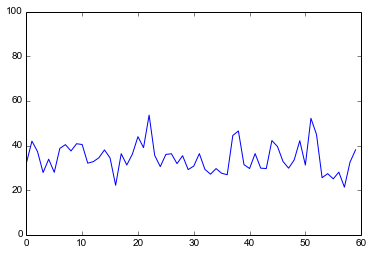

In [220]:
data_filename = '/media/amir/DATA/work/Dropbox/Nematodes/'+\
                'TransposonPaperAnalysis/18S_tree/data/GC.txt'

data = [l.rstrip().split(',') for l in 
        open(data_filename,'r').readlines()]

gz_lines = open('18S_tree/data/genome_sizes.csv','r').readlines()[1:]

gz = {}
for l in gz_lines:
    line_part = l.rstrip().split('\t')
    code = line_part[0]
    size = line_part[6]
    if code:
        for d in data:
            if d[0] == code:
                d.append(size)
for d in data:
    if len(d) == 6:
        d.append('0')
        
%matplotlib inline
from matplotlib import pyplot as plt

print data[:2]

data = sorted(data, key=lambda i: float(i[5]), reverse=True)

x = range(len(data))

N50 = [l[3] for l in data]
aGC = [l[4] for l in data]
aLength = [l[5] for l in data]
gLength = [l[6] for l in data]
plt.ylim([0,100])

a = plt.plot(x, aGC)

#GC content sorted by assembly length

### N50 sv assembly length

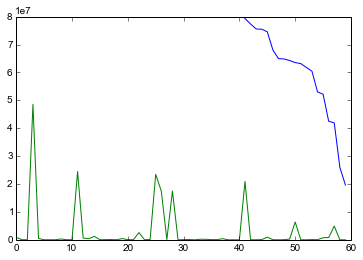

In [221]:
plt.ylim([0,80000000])
plt.plot(x, aLength)
plt.plot(x, N50)

# N50 sorted by assembly length

### GC content vs genome size

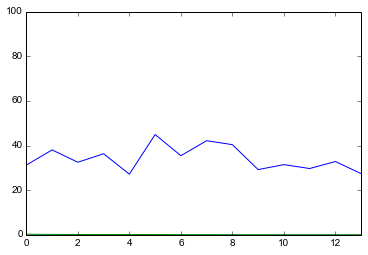

In [244]:
data = sorted(data, key=lambda i: float(i[6]), reverse=True)
N50 = [l[3] for l in data]
aGC = [l[4] for l in data]
aLength = [l[5] for l in data]
gLength = [l[6] for l in data]

plt.ylim([0,100])
plt.xlim([0,13])
plt.plot(x, aGC)
plt.plot(x, gLength)

# GC content in 13 nematodes sorted by genome size (not assembly)

### Add genome size and assembly size to Project

In [245]:
for f in chain(*[r.features for r in pj.records]):
    if 'keep' in f.qualifiers.keys():
        code = f.qualifiers['keep'][0]
        for d in data:
            if code == d[0]:
                gsize = d[-1]
                if not gsize == '0':
                    gsize = [d[-1]]
                f.qualifiers['assembly_length'] = [d[5]]
                f.qualifiers['genome_size'] = [gsize]

### Save the Project

In [246]:
# 18S_tree_reprophylo_project does not have Haor, which is a shame because
# Haor has interesting RNAi pathway results.
# V2 includes Haor
pickle_pj(pj, '18S_tree/18S_tree_reprophylo_project_v2')

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened


'18S_tree/18S_tree_reprophylo_project_v2'

## 1.8 Trim the alignment
This is still the full dataset with all the sequences. The trimming is done with the gappyout option in trimal

In [247]:
trimal = TrimalConf(pj)
pj.trim([trimal])

trimal -in 647471429710181.55_18S@SINA.fasta -gappyout


In [248]:
pj.write_trimmed_alns(id=['source_organism','original_id'])

['18S@SINA@gappyout_trimmed_aln.fasta']

In [253]:
pickle_pj(pj, '18S_tree/18S_tree_reprophylo_project_v2')

'18S_tree/18S_tree_reprophylo_project_v2'

In [1]:
from reprophylo import * 
pj = unpickle_pj('18S_tree/18S_tree_reprophylo_project_v2', git=False)

DEBUG:Cloud:Log file (/home/amir/.picloud/cloud.log) opened
/media/amir/DATA/work/Dropbox/python_modules/reprophylo.py:4673: UserWarning: Upgrading Project to v1
  warnings.warn('Upgrading Project to v1')


In [4]:
pj.alignments.keys()

['18S@SINA']

## 1.9 Run preliminary ML tree on full dataset
This is a preliminary RAxML ML search with fast ML search and sh-like supports

In [9]:
raxml = RaxmlConf(pj, method_name='fF_fJ', preset = 'fF_fJ', cmd='raxmlHPC-PTHREADS-AVX')

raxmlHPC-PTHREADS-AVX -f F -m GTRGAMMA -n 526801429715510.1_18S@SINA@gappyout0 -p 378 -s 526801429715510.1_18S@SINA@gappyout.fasta -T 4
raxmlHPC-PTHREADS-AVX -f J -m GTRGAMMA -n 526801429715510.1_18S@SINA@gappyout1 -p 945 -s 526801429715510.1_18S@SINA@gappyout.fasta -t RAxML_fastTree.526801429715510.1_18S@SINA@gappyout0 -T 4


In [10]:
pj.tree([raxml])

## 1.10 Make a figure of the preliminary large tree

In [18]:
# Make an output directory
try:
    os.mkdir('18S_tree/fasttree_figure')
except:
    pass

In [25]:
# Annotate the tree
pj.clear_tree_annotations()
pj.annotate('18S_tree/fasttree_figure', 'keep','Alyr',['source_organism','source_original_id'],
            fsize=18, scale=600)

<html>
<A href=18S_tree/fasttree_figure/526801429715510.1_18S@SINA@gappyout.png>526801429715510.1_18S@SINA@gappyout</A><BR>
</html>
18S_tree/fasttree_figure


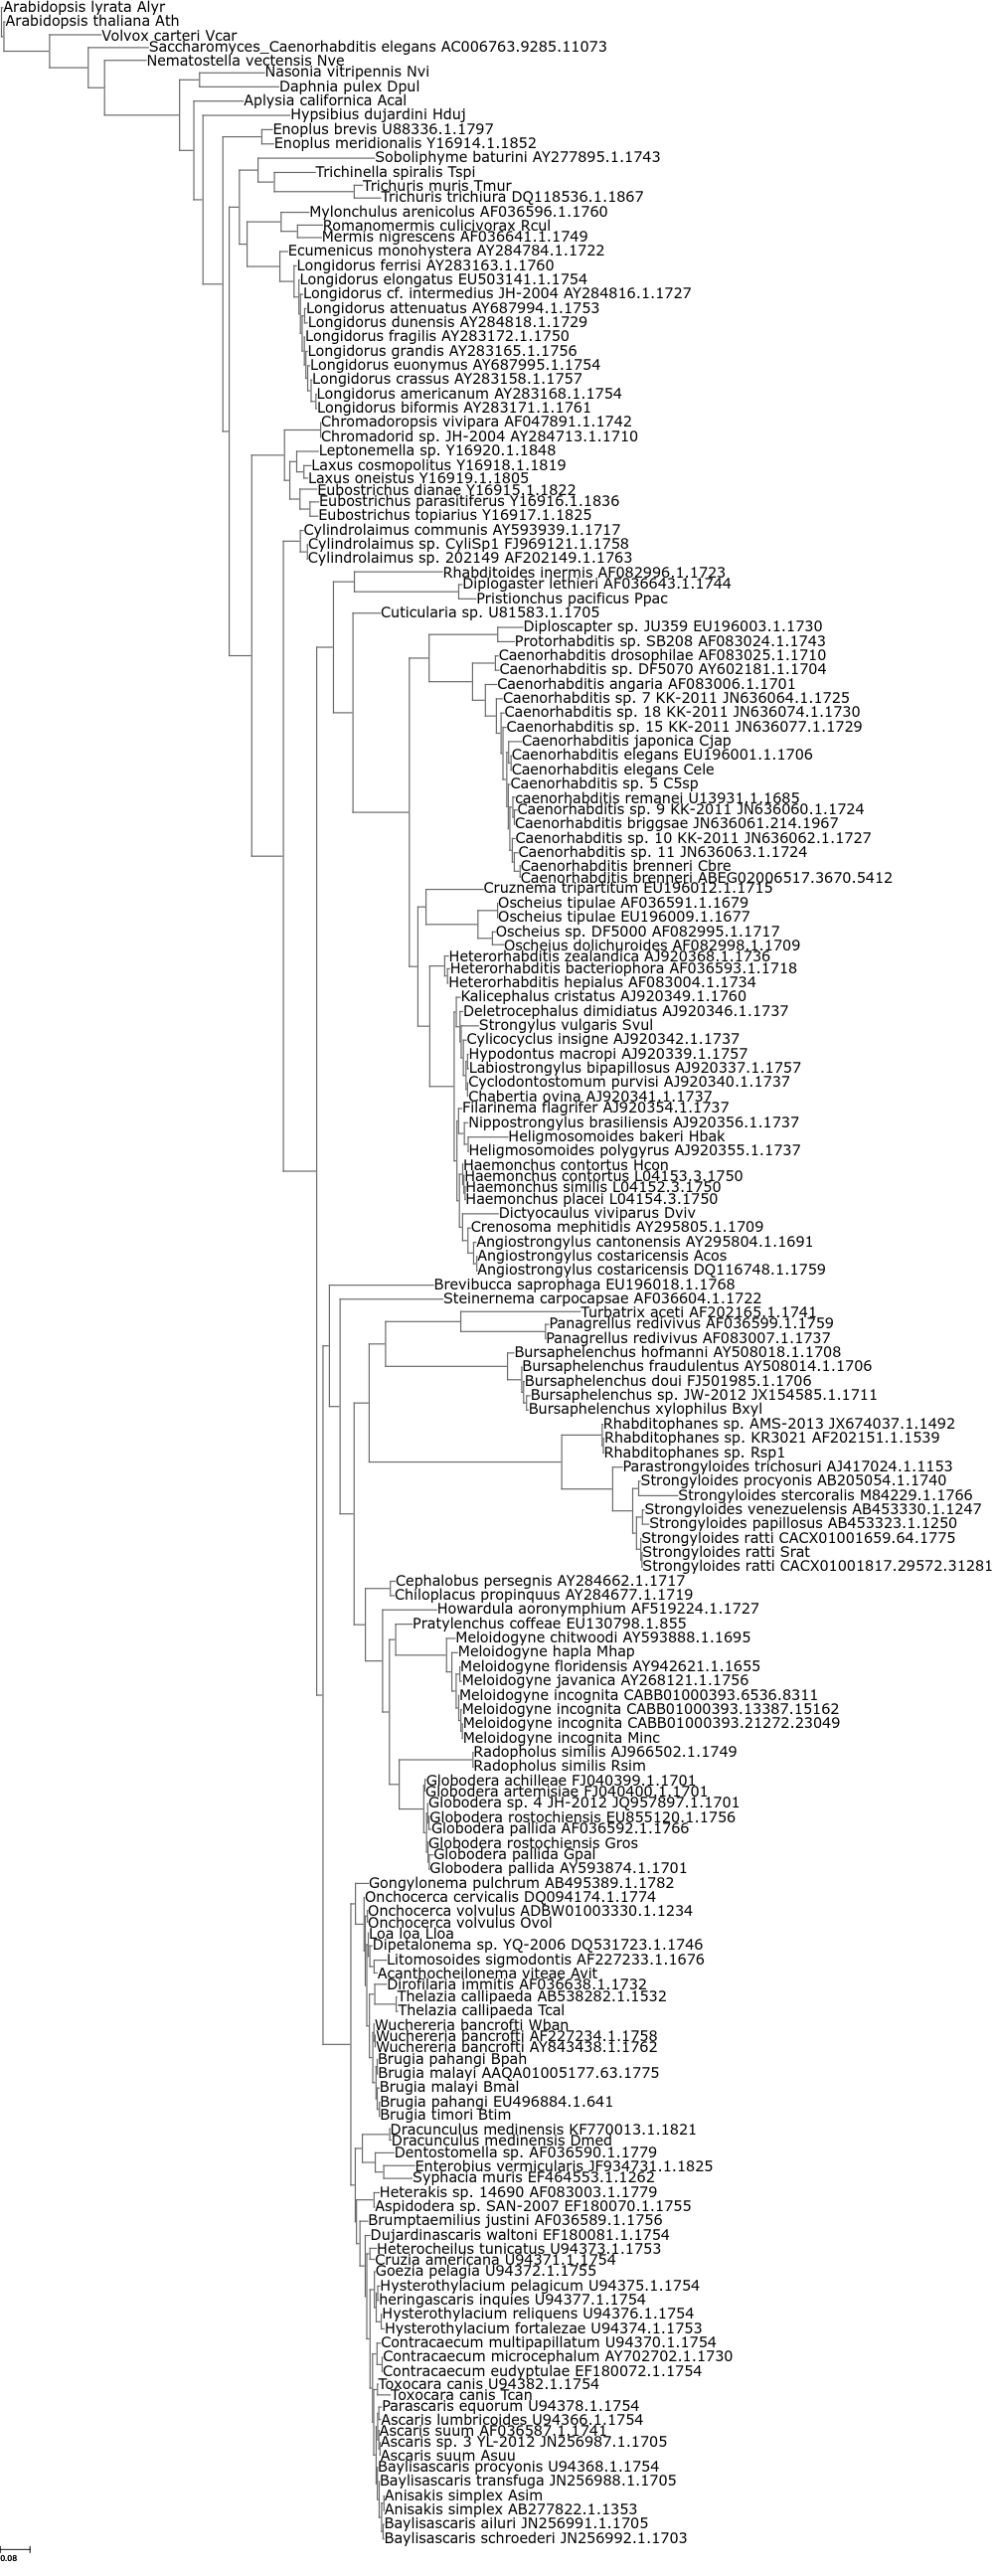

In [11]:
from IPython.display import Image
Image('18S_tree/fasttree_figure/526801429715510.1_18S@SINA@gappyout.png')

## 1.11 Run final ML tree on full dataset
With 50 starting trees and thorough bootstrap

In [26]:
raxml = RaxmlConf(pj, method_name='fd_b_fb_50ML',
                  cmd='raxmlHPC-PTHREADS-AVX',
                  preset='fd_b_fb', threads=4,
                  cline_args={"-N": "50"})
pj.tree([raxml])

raxmlHPC-PTHREADS-AVX -f d -m GTRGAMMA -n 459491429716950.94_18S@SINA@gappyout0 -p 998 -s 459491429716950.94_18S@SINA@gappyout.fasta -T 4 -N 50
raxmlHPC-PTHREADS-AVX -b 525 -m GTRGAMMA -n 459491429716950.94_18S@SINA@gappyout1 -p 462 -s 459491429716950.94_18S@SINA@gappyout.fasta -T 4 -N 100
raxmlHPC-PTHREADS-AVX -f b -m GTRGAMMA -n 459491429716950.94_18S@SINA@gappyout2 -p 589 -s 459491429716950.94_18S@SINA@gappyout.fasta -t RAxML_bestTree.459491429716950.94_18S@SINA@gappyout0 -T 4 -z RAxML_bootstrap.459491429716950.94_18S@SINA@gappyout1


In [27]:
pickle_pj(pj, '18S_tree/18S_tree_reprophylo_project_v2')

'18S_tree/18S_tree_reprophylo_project_v2'

##1.12 Make a figure of the final large tree

In [28]:
try:
    os.mkdir('18S_tree/ML_tree_figure')
except:
    pass

In [30]:
pj.clear_tree_annotations()
pj.annotate('18S_tree/ML_tree_figure','keep','Alyr',['source_organism','source_original_id'],
            fsize=18, scale=600, node_support_dict={'black':[100,90]})

<html>
<A href=18S_tree/ML_tree_figure/459491429716950.94_18S@SINA@gappyout.png>459491429716950.94_18S@SINA@gappyout</A><BR>
<A href=18S_tree/ML_tree_figure/526801429715510.1_18S@SINA@gappyout.png>526801429715510.1_18S@SINA@gappyout</A><BR>
</html>
18S_tree/ML_tree_figure


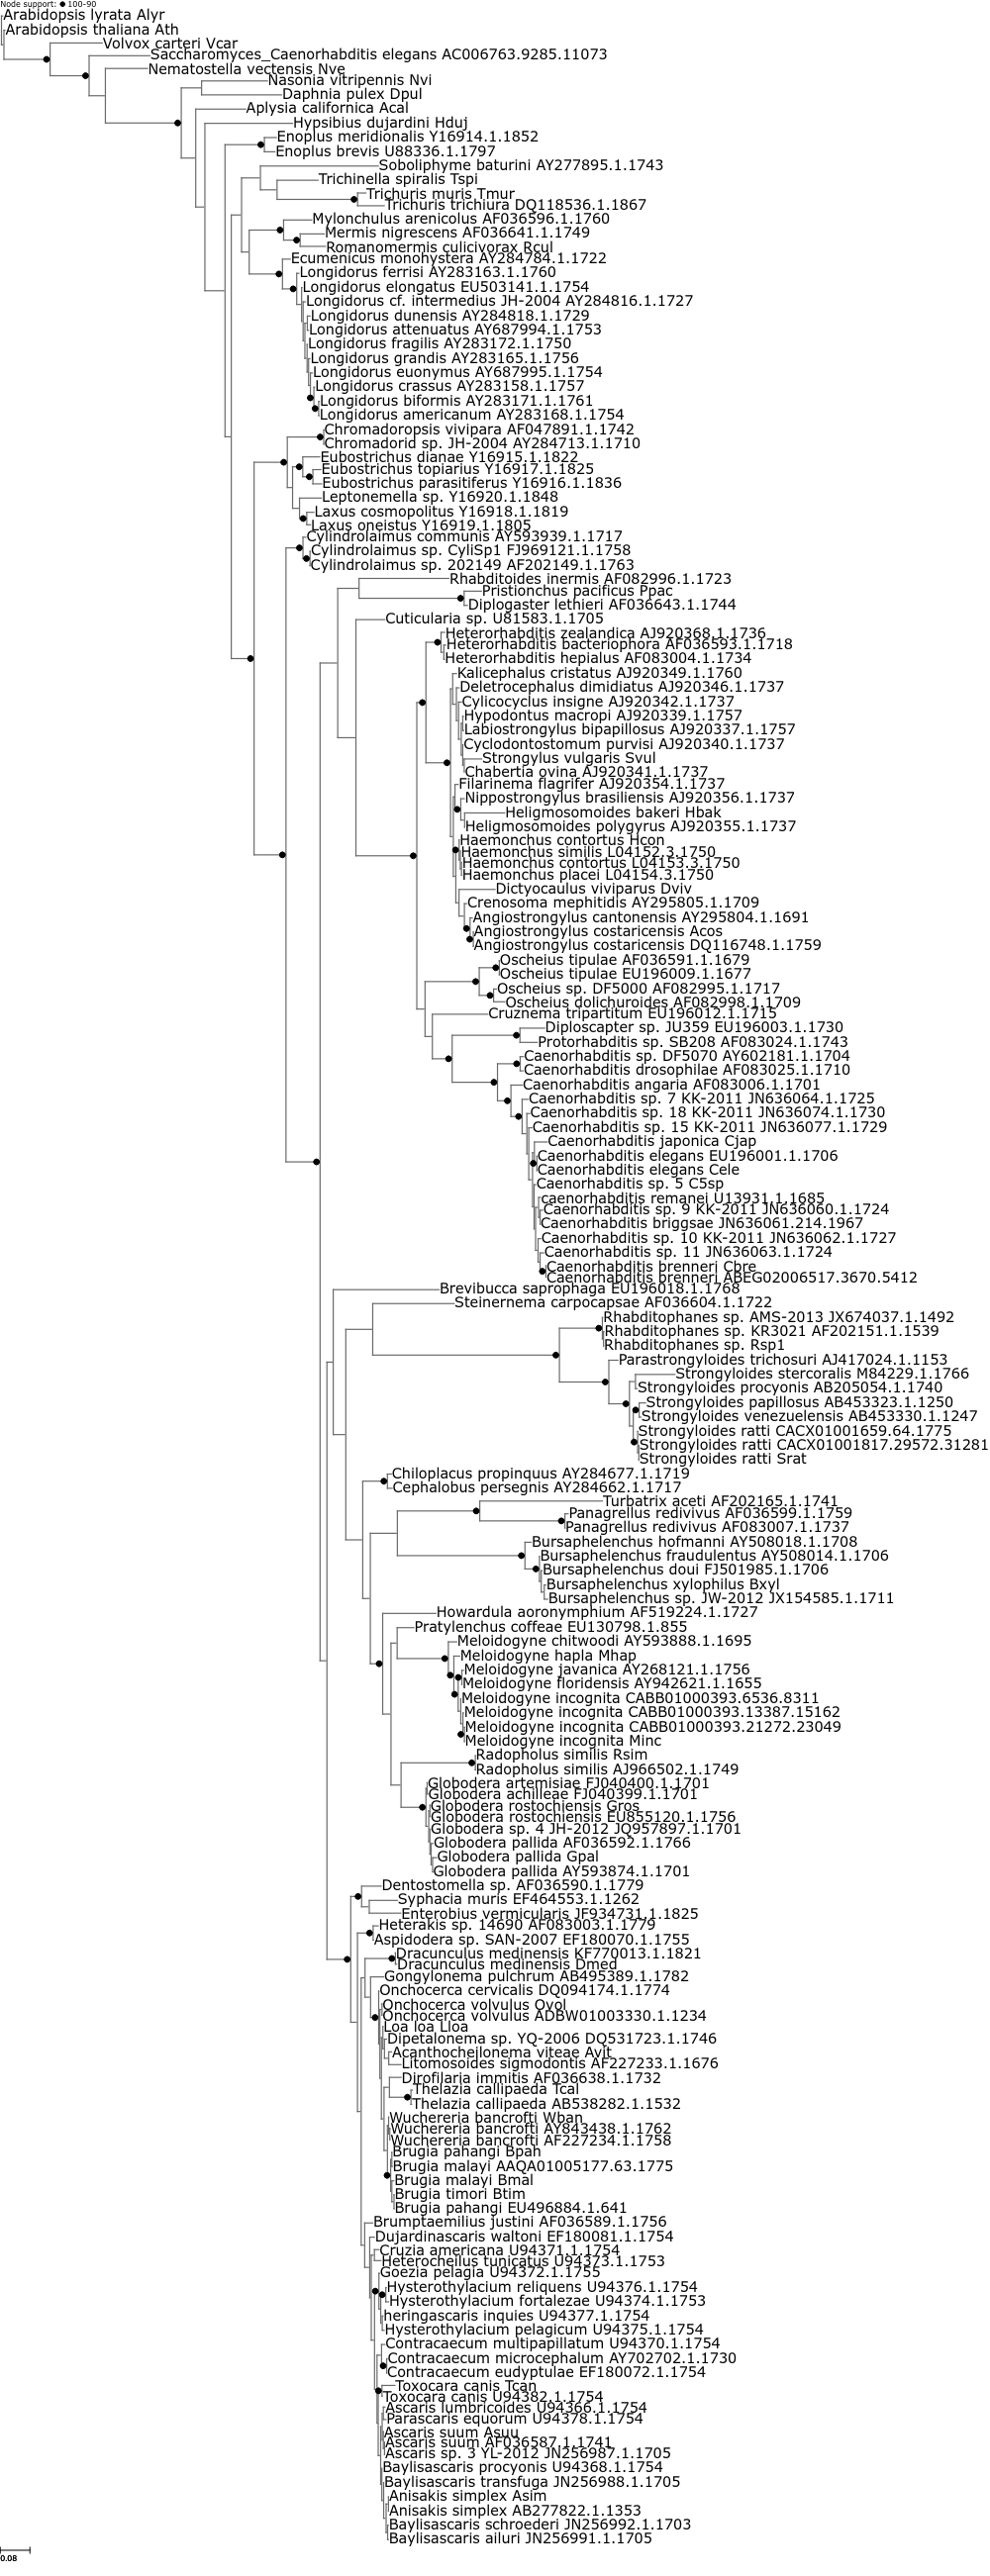

In [13]:
Image('18S_tree/ML_tree_figure/459491429716950.94_18S@SINA@gappyout.png')

## 1.13 Make a reduced tree with only genome reps
The full tree is kept and a trimmed tree is added under a different key. The reduced tree will be a start tree in the phylobayes run

In [91]:
# Make a copy of the big tree object
silva_tree = pj.ft('18S@SINA@gappyout@fd_b_fb_50ML')

# Ladderize it
silva_tree.ladderize(1)

# Root it
silva_tree.set_outgroup(silva_tree.search_nodes(keep='Alyr')[0])

# Delete nodes that do nto represent a genome assembly
for n in silva_tree.traverse():
    leaves = n.get_leaves()
    delete = 1
    for leaf in leaves:
        if 'keep' in get_qualifiers_dictionary(pj, leaf.name):
            delete = 0

    if delete == 1:
        n.delete()

# Root the trimmed tree and ladderize it
silva_tree.set_outgroup(silva_tree.search_nodes(source_original_id='Alyr')[0])
silva_tree.ladderize(0)

# Manually add the trimmed tree to the Project
   # trees attribute holds the trees dict      # values are a list of tree object and nhx string
pj.trees["18S@SINA@gappyout@trimmed_leaves"] = [silva_tree, silva_tree.write(features=[])]

# Save the Project with the added trimmed tree
pickle_pj(pj, '18S_tree/18S_tree_reprophylo_project_v2')

'18S_tree/18S_tree_reprophylo_project_v2'

## 1.14 Make a trimmed alignment with only the sequences of the trimmed tree
To be used as a sequence matrix in the Phylobayes run

In [95]:
# Make a copy of the full dataset alignment object
full_t_aln = pj.fta('18S@SINA@gappyout')

# Make a list contining aligned records only of species that are in the trimmed tree
reduced_t_aln = []
for record in full_t_aln:
    quals = get_qualifiers_dictionary(pj, record.id)
    if 'keep' in quals.keys():
        reduced_t_aln.append(record)
        
# Manually sdd the records as an alignment object into the dict in the trimmed_alignment attribute
pj.trimmed_alignments['18S@SINAR@gappyout'] = MultipleSeqAlignment(reduced_t_aln,
                                                                   alphabet=IUPAC.ambiguous_dna)
# Save the Project
pickle_pj(pj, '18S_tree/18S_tree_reprophylo_project_v2')

'18S_tree/18S_tree_reprophylo_project_v2'

## 1.15 Write the reduced ML tree to a file for phylobayes

In [96]:
pj.ft('18S@SINA@gappyout@trimmed_leaves').write(outfile='18S_tree/data/18S@SINA@gappyout@trimmed_leaves.nwk')

returning tree object 18S@SINA@gappyout@trimmed_leaves


## 1.16 Build a phylobayes tree
Two chains, cutoff of 0.1 maximum differences between the chains and  effective sizes of at least 100.

In [40]:
pb = PbConf(pj, alns=["18S@SINAR@gappyout"],
            cline_args=dict(nchain="2 100 0.1 100",
                            gtr=True,
                            cat=True,
                            t='18S_tree/data/18S@SINA@gappyout@trimmed_leaves.nwk'))

pb -d 822861429729532.25_18S@SINAR@gappyout.phylip -gtr -nchain 2 100 0.1 100 -t 18S_tree/data/18S@SINA@gappyout@trimmed_leaves.nwk -cat 822861429729532.25_18S@SINAR@gappyout


In [ ]:
pj.tree([pb])

### Further remove some leaves from the bayesian trimmed tree that I want to exclude from the analysis

In [4]:
# remove Ooch from 18S@SINA@gappyout@dna_cat_gtr

Ooch = pj.trees['18S@SINA@gappyout@dna_cat_gtr'][0].search_nodes(keep="Ooch")[0]
Ooch.delete()

# remove Hbak from 18S@SINA@gappyout@dna_cat_gtr

Hbak = pj.trees['18S@SINA@gappyout@dna_cat_gtr'][0].search_nodes(keep="Hbak")[0]
Hbak.delete()

# remove Mjav from 18S@SINA@gappyout@dna_cat_gtr

Mjav = pj.trees['18S@SINA@gappyout@dna_cat_gtr'][0].search_nodes(keep="Mjav")[0]
Mjav.delete()

In [100]:
Ooch.feature_id

'denovo135_f0'

In [3]:
Hbak.feature_id

'denovo181_f0'

In [5]:
Mjav.feature_id

'denovo2_f0'

In [102]:
pj.ft('dna_cat_gtr').search_nodes(keep="Hduj")[0].feature_id

returning tree object 18S@SINA@gappyout@dna_cat_gtr


'denovo173_f0'

In [8]:
# remove Ooch from 1.treelist and 2.treelist
os.rename('./18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.1.treelist',
          './18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.1.treelist_orig_backup')
os.rename('./18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.2.treelist',
          './18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.2.treelist_orig_backup')

trees1 = open('./18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.1.treelist_orig_backup','r').readlines()
hndl = open('./18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.1.treelist','wt')

i = 0
for t in trees1:
    t = t.rstrip()
    T = Tree(t, format=5)
    Hduj = T.search_nodes(name="denovo173_f0")[0]
    T.set_outgroup(Hduj)
    Ooch = T.search_nodes(name="denovo135_f0")[0]
    Ooch.delete()
    Hbak = T.search_nodes(name="denovo181_f0")[0]
    Hbak.delete()
    Mjav = T.search_nodes(name="denovo2_f0")[0]
    Mjav.delete()
    if 'NoName' in T.get_leaf_names():
        RuntimeError('Something wrong tree %i'%i)
    hndl.write("%s\n"%T.write(format=5))
    i += 1
hndl.close()

trees2 = open('./18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.2.treelist_orig_backup','r').readlines()
hndl = open('./18S_tree/phylobayes/822861429729532.25_18S@SINAR@gappyout.2.treelist','wt')

for t in trees2:
    t = t.rstrip()
    T = Tree(t, format=5)
    Hduj = T.search_nodes(name="denovo173_f0")[0]
    T.set_outgroup(Hduj)
    Ooch = T.search_nodes(name="denovo135_f0")[0]
    Ooch.delete()
    Hbak = T.search_nodes(name="denovo181_f0")[0]
    Hbak.delete()
    Mjav = T.search_nodes(name="denovo2_f0")[0]
    Mjav.delete()
    if 'NoName' in T.get_leaf_names():
        RuntimeError('Something wrong tree %i'%i)
    hndl.write("%s\n"%T.write(format=5))
    i += 1
hndl.close()

# Update the string representation of the tree to exclude these species
pj.trees['18S@SINA@gappyout@dna_cat_gtr'][1] = pj.trees['18S@SINA@gappyout@dna_cat_gtr'][0].write(features=[])

# Save the Project
pickle_pj(pj, '18S_tree/18S_tree_reprophylo_project_v2')

# Move phylobayes output files
import glob
filnames = glob.glob('./*SINAR*')
for f in filnames:
    os.rename(f,'./18S_tree/phylobayes/%s'%f)

## 1.17 Make a summary table with the analysis taxa

In [14]:
# Make a list of genome codes to include
import TE
genomes = TE.genomes_dict('Genomes/', code_file='genome_assembly_files_v3.csv')
genomes.pop('Hbak')
genomes.pop('Mjav')
genomes.pop('Eela')

# Read the taxonomy file
lines = open('18S_tree/data/species_names.csv','r').readlines()

# Make a dictionary with species, order and Bclade for each code
species = {}
for l in lines:
    code, sp, group, clade = l.rstrip().split('\t')
    species[code] = {'species': sp,
                     'group': group,
                     'clade': clade}

# Write the table
from itertools import chain
for code in genomes:
    for f in [i for i in chain(*[r.features for r in pj.records])]:
        if 'keep' in f.qualifiers.keys() and f.qualifiers['keep'][0] == code:
            n50 = f.qualifiers['n50'][0]
            print "%s\t%s\t%s\t%s\t%s"%(code,
                                species[code]['species'],
                                species[code]['clade'],
                                str(int(n50)),
                                genomes[code])
            
#code   binomial                Bclade  N50     genome assembly filename           

Mchi	Meloidogyne chitwoodi	IV	70023	1_uw_chwd.change.a.fasta
Asim	Anisakis simplex	III	9290	Anisakis_simplex_v1.5.fa_4
Ppac	Pristionchus pacificus	V	1244534	p_pacificus.PRJNA12644.WS238.genomic.fa
Bmal	Brugia malayi	III	191089	b_malayi.PRJNA10729.WS238.genomic.fa
Pred	Panagrellus redivivus	IV	270080	Panagrellus_redivivus.KB454917-KB455574.fasta
Gpal	Globodera pallida	IV	121687	Gpal.v1.0.fas
Hduj	Hypsibius dujardini	O	50531	Hypsibius_dujardini_nHd.2.3.abv500.fna
Mhap	Meloidogyne hapla	IV	37608	m_hapla.PRJNA29083.WS238.genomic.fa
Avit	Acanthocheilonema viteae	III	25808	Acanthocheilonema_viteae_v1.0.fa
Crem	Caenorhabditis remanei	V	435512	c_remanei.PRJNA53967.WS238.genomic.fa
Wban	Wuchereria bancrofti	III	5161	Wuchereria_bancrofti_v2.fa_4
Ptri	Parastrongyloides trichosuri	IV	836942	Parastrongyloides_trichosuri_v2.fa_4
Cele	Caenorhabditis elegans	V	17493829	c_elegans.WS235.genomic.fa
Spap	Strongyloides papillosus	IV	86359	Strongyloides_papillosus_v2.1.fa_4
Rsim	Radopholus similis	IV	14057	

In [15]:
# Save the Project
pickle_pj(pj,'18S_tree/18S_tree_reprophylo_project_v2')

'18S_tree/18S_tree_reprophylo_project_v2'

## 1.18 Make plain tree figure

In [1]:
from reprophylo import *
pj=unpickle_pj('18S_tree/18S_tree_reprophylo_project_v2', git=False)

# Collect nodes we'll want to point to later
cele = pj.fr('18S', filter=[['keep','Cele']])[0].id
cang = pj.fr('18S', filter=[['keep','Cang']])[0].id
alyr = pj.fr('18S', filter=[['keep','Alyr']])[0].id
hduj = pj.fr('18S', filter=[['keep','Hduj']])[0].id
cjap = pj.fr('18S', filter=[['keep','Cjap']])[0].id

# Make a copy of the bayes tree Tree object
t = pj.ft('dna_cat_gtr')

# Root it
t.set_outgroup(alyr)

# Remove outgroup except the tardigrade
t = t.get_common_ancestor(hduj, cang)

# Ladderize
t.ladderize(0)

# Make sure the tardigrade is the outgroup
t.set_outgroup(hduj)

# Set the root length (not the outgroup branch length) to 0
t.dist=0

# Node and Tree basic style
ns = None
ns = NodeStyle(size=0)
ts = TreeStyle()
ts.show_leaf_name = False
ts.scale = 300
ns['hz_line_width']=2
ns['vt_line_width']=2

# For each node, set the style, 
# if it has support > 0.95 put a bullet
# if it is a leaf, put the code and clade as  text label
for n in t.traverse():
    n.set_style(ns)
    if n.is_leaf():
        n.add_face(TextFace(get_qualifiers_dictionary(pj, n.name)['keep']),0,position="branch-right")
        n.support = 0
    if n.support > 0.95:
        n.add_face(CircleFace(3,'black'),0,position="float")

faces = t.render("18S_tree/bys_18S_tree.png", w=1000, tree_style=ts)

DEBUG:Cloud:Log file (/root/.picloud/cloud.log) opened


returning records list of locus 18S and filter [['keep', 'Cele']]
returning records list of locus 18S and filter [['keep', 'Cang']]
returning records list of locus 18S and filter [['keep', 'Alyr']]
returning records list of locus 18S and filter [['keep', 'Hduj']]
returning records list of locus 18S and filter [['keep', 'Cjap']]
returning tree object 18S@SINA@gappyout@dna_cat_gtr


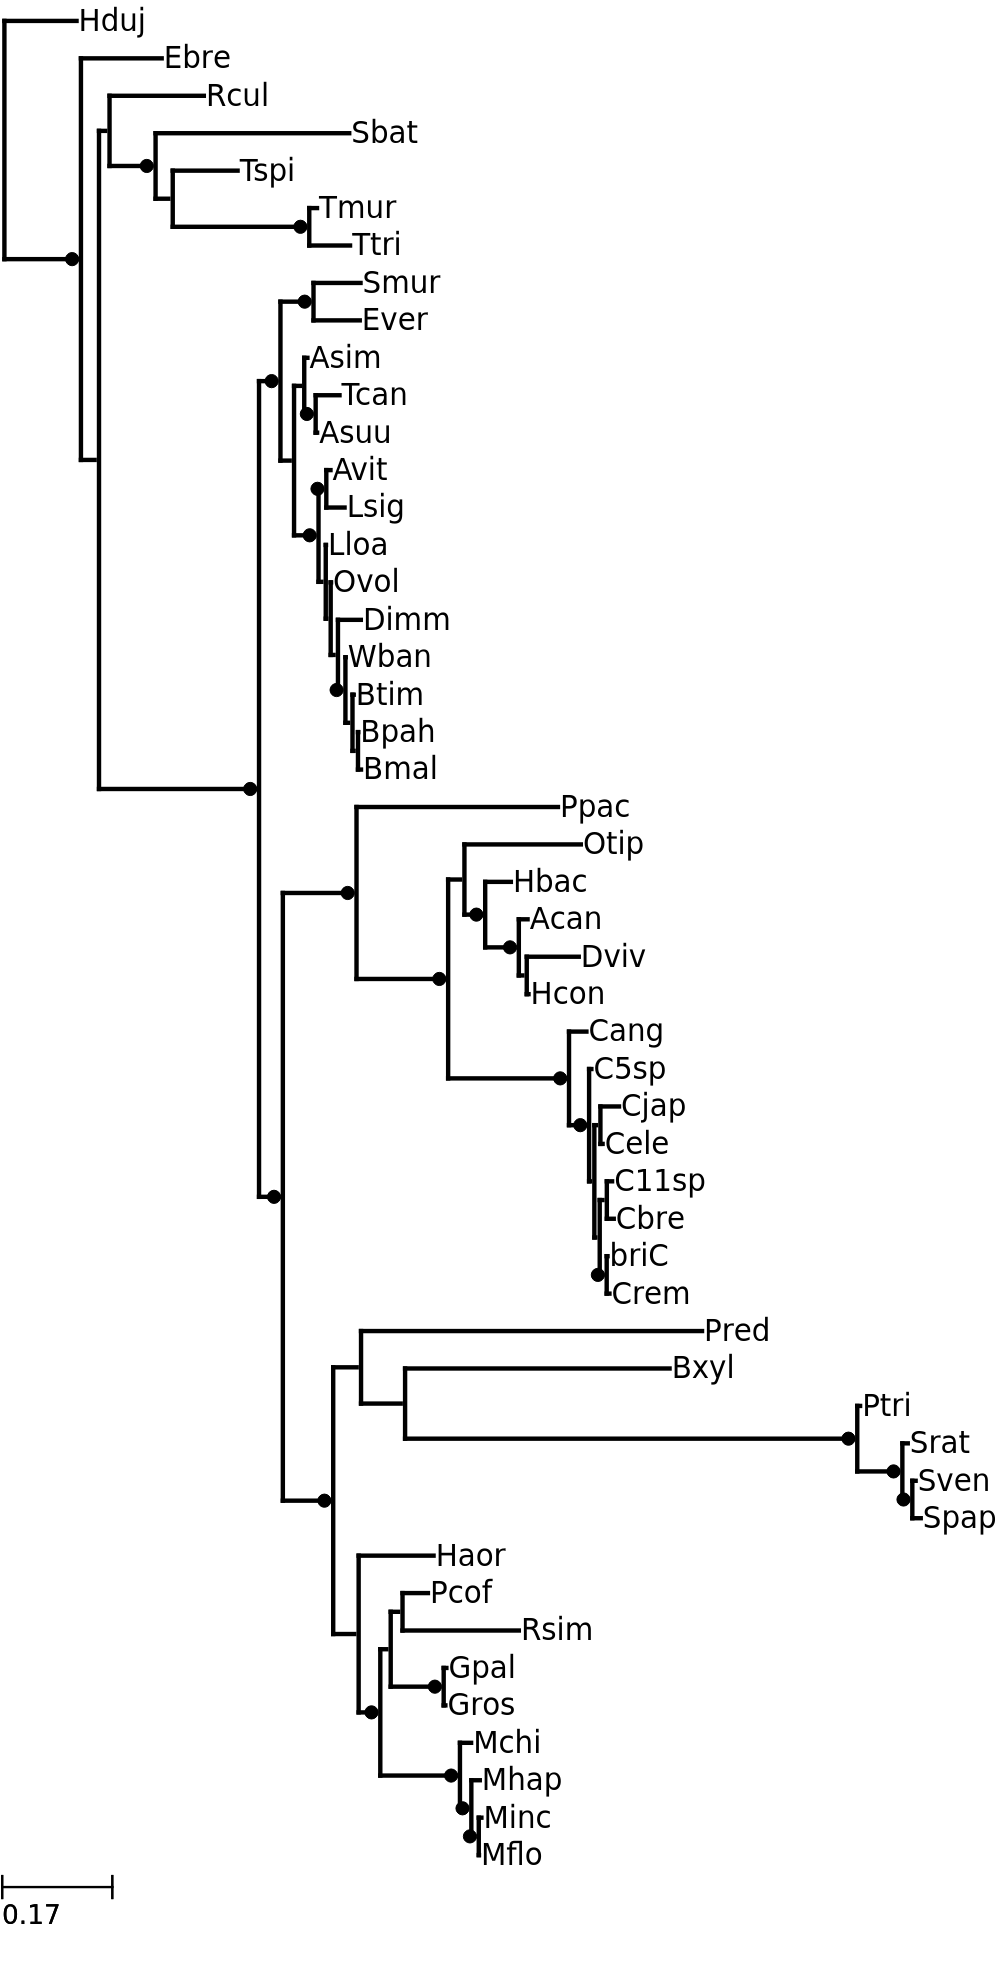

In [5]:
from IPython.display import *
Image("18S_tree/bys_18S_tree.png", width=300)